The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1
!pip install -U mxnet-cu101==1.7.0


# Transformador
:label:`sec_transformer`


Comparamos CNNs, RNNs e autoatenção em :numref:`subsec_cnn-rnn-self-attention`. Notavelmente, a auto-atenção desfruta de computação paralela e do comprimento máximo de caminho mais curto. Portanto, naturalmente, é atraente projetar profundamente
  arquiteturas usando auto-atenção. Ao contrário dos modelos anteriores de autoatenção que ainda contam com RNNs para representações de entrada
cite:`Cheng.Dong.Lapata.2016,Lin.Feng.Santos.ea.2017,Paulus.Xiong.Socher.2017`, o modelo do transformador é exclusivamente baseado em mecanismos de atenção sem qualquer camada convolucional ou recorrente :cite:`Vaswani.Shazeer.Parmar.ea.2017`.  Embora originalmente propostos para aprendizagem de sequência para sequência em dados de texto, os transformadores têm sido difundidos em uma ampla gama de aplicações modernas de aprendizagem profunda, como nas áreas de linguagem, visão, fala e aprendizagem por reforço.

## Modelo


Como uma instância da arquitetura codificador-decodificador,
a arquitetura geral do transformador é apresentada em :numref:`fig_transformer`. Como podemos ver, o transformador é composto por um codificador e um decodificador. Diferente de
Atenção Bahdanau para o aprendizado de sequência para sequência em :numref:`fig_s2s_attention_details`, os *embeddings* de sequência de entrada (origem) e saída (destino) são adicionados com codificação posicional antes de serem alimentados no codificador e no decodificador
que empilham módulos baseados em autoatenção.

![A arquitetura do transformador.](http://d2l.ai/_images/transformer.svg)
:width:`500px`
:label:`fig_transformer`


Agora fornecemos uma visão geral da arquitetura do transformador em :numref:`fig_transformer`. Em um alto nível, o codificador do transformador é uma pilha de várias camadas idênticas, onde cada camada
tem duas subcamadas (qualquer uma é denotada como $\mathrm{sublayer}$).
O primeiro é um pooling de autoatenção com várias *heads* e o segundo é uma rede *feed-forward* posicional. Especificamente, na autoatenção do codificador, as consultas, as chaves e os valores são todos provenientes das saídas da camada do codificador anterior. Inspirado no design ResNet em :numref:`sec_resnet`, uma conexão residual é empregada
em torno de ambas as subcamadas. No transformador, para qualquer entrada
$\mathbf{x} \in \mathbb{R}^d$ em qualquer posição da sequência,
exigimos que $\mathrm{sublayer}(\mathbf{x}) \in 
 \mathbb{R}^d$ para que a conexão residual $\mathbf{x} + \mathrm{sublayer}(\mathbf{x}) \in \mathbb{R}^d$ seja viável.
Esta adição da conexão residual é imediatamente
seguida pela normalização da camada :cite:`Ba.Kiros.Hinton.2016`.
Como resultado, o codificador do transformador produz uma representação vetorial $d$-dimensional para cada posição da sequência de entrada.

O decodificador do transformador também é uma pilha de várias camadas idênticas com conexões residuais e normalizações de camada.
Além das duas subcamadas descritas no codificador, o decodificador insere uma terceira subcamada, conhecida como atenção do codificador-decodificador,
entre esses dois. Na atenção do codificador-decodificador, as consultas são das saídas da camada do decodificador anterior e as chaves e valores são das saídas do codificador do transformador. Na autoatenção do decodificador, consultas, chaves e valores são todos provenientes das saídas da camada do decodificador anterior. No entanto, cada posição no decodificador só pode atender a todas as posições no decodificador até aquela posição. Essa atenção *mascarada* preserva a propriedade auto-regressiva, garantindo que a previsão dependa apenas dos tokens de saída que foram gerados.


Já descrevemos e implementamos a atenção multi-head com base em produtos escalonados em :numref:`sec_multihead-attention` e codificação posicional em :numref:`subsec_positional-encoding`. A seguir, implementaremos o restante do modelo do transformador.


In [1]:
import math
import pandas as pd
from mxnet import autograd, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

## Redes *Positionwise Feed-Forward*

A rede feed-forward *positionwise* transforma a representação em todas as posições de sequência usando o mesmo MLP.
É por isso que o chamamos de *positionwise*. Na implementação abaixo,
o `X` de entrada com forma (tamanho do lote, número de etapas de tempo ou comprimento da sequência em tokens, número de unidades ocultas ou dimensão do recurso) será transformado por um MLP de duas camadas em um tensor de saída de forma (tamanho do lote, número de passos de tempo, `ffn_num_outputs`).


In [2]:
#@save
class PositionWiseFFN(nn.Block):
    def __init__(self, ffn_num_hiddens, ffn_num_outputs, **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Dense(ffn_num_hiddens, flatten=False,
                               activation='relu')
        self.dense2 = nn.Dense(ffn_num_outputs, flatten=False)

    def forward(self, X):
        return self.dense2(self.dense1(X))

O seguinte exemplo
mostra que a dimensão mais interna
de um tensor muda para
o número de saídas em
a rede *feed-forward* posicionada.
Uma vez que o mesmo MLP se transforma
em todas as posições,
quando as entradas em todas essas posições são as mesmas,
suas saídas também são idênticas.


In [3]:
ffn = PositionWiseFFN(4, 8)
ffn.initialize()
ffn(np.ones((2, 3, 4)))[0]

array([[ 0.00239431,  0.00927085, -0.00021069, -0.00923989, -0.0082903 ,
        -0.00162741,  0.00659031,  0.00023905],
       [ 0.00239431,  0.00927085, -0.00021069, -0.00923989, -0.0082903 ,
        -0.00162741,  0.00659031,  0.00023905],
       [ 0.00239431,  0.00927085, -0.00021069, -0.00923989, -0.0082903 ,
        -0.00162741,  0.00659031,  0.00023905]])

## Conexão residual e normalização de camada


Agora vamos nos concentrar no componente "add & norm" em :numref:`fig_transformer` Como descrevemos no início
desta seção, esta é uma conexão residual imediatamente
seguido pela normalização da camada. Ambos são essenciais para arquiteturas profundas eficazes.

Em :numref:`sec_batch_norm`, explicamos como a normalização em lote recentraliza e redimensiona os exemplos dentro
um minibatch. A normalização de camada é igual à normalização em lote, exceto que a primeira normaliza em toda a dimensão do recurso. Apesar de suas aplicações difundidas em visão computacional, a normalização em lote é geralmente empiricamente menos eficaz do que a normalização de camada em tarefas de processamento de linguagem natural, cujas entradas são frequentemente sequências de comprimento variável.

O fragmento de código a seguir compara a normalização em diferentes dimensões por normalização de camada e normalização de lote.


In [4]:
ln = nn.LayerNorm()
ln.initialize()
bn = nn.BatchNorm()
bn.initialize()
X = np.array([[1, 2], [2, 3]])
# Compute mean and variance from `X` in the training mode
with autograd.record():
    print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: [[-0.99998  0.99998]
 [-0.99998  0.99998]] 
batch norm: [[-0.99998 -0.99998]
 [ 0.99998  0.99998]]


Agora podemos implementar a classe `AddNorm`
usando uma conexão residual seguida pela normalização da camada.
O *dropout* também é aplicado para regularização.


In [5]:
#@save
class AddNorm(nn.Block):
    def __init__(self, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm()

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

A conexão residual requer que
as duas entradas sejam da mesma forma
de modo que o tensor de saída também tenha a mesma forma após a operação de adição.


In [6]:
add_norm = AddNorm(0.5)
add_norm.initialize()
add_norm(np.ones((2, 3, 4)), np.ones((2, 3, 4))).shape

(2, 3, 4)

## *Encoder*

Com todos os componentes essenciais para montar o *encoder* do transformador, vamos começar implementando uma única camada dentro do *encoder*. A seguinte classe `EncoderBlock` contém duas subcamadas: autoatenção com várias *heads* e redes de alimentação em posição posicionada, onde uma conexão residual seguida pela normalização da camada é empregada em torno de ambas as subcamadas.


In [7]:
#@save
class EncoderBlock(nn.Block):
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout,
                 use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(
            num_hiddens, num_heads, dropout, use_bias)
        self.addnorm1 = AddNorm(dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

Como podemos ver,
qualquer camada no *encoder* do transformador
não altera a forma de sua entrada.


In [8]:
X = np.ones((2, 100, 24))
valid_lens = np.array([3, 2])
encoder_blk = EncoderBlock(24, 48, 8, 0.5)
encoder_blk.initialize()
encoder_blk(X, valid_lens).shape

(2, 100, 24)

Na seguinte implementação do *encoder* de transformador,
empilhamos instâncias `num_layers` das classes` EncoderBlock` acima. Uma vez que usamos a codificação posicional fixa
cujos valores estão sempre entre -1 e 1,
nós multiplicamos os valores dos *embeddings* de entrada aprendíveis
pela raiz quadrada da dimensão de incorporação
para redimensionar antes de resumir a incorporação de entrada e a codificação posicional.


In [9]:
#@save
class TransformerEncoder(d2l.Encoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for _ in range(num_layers):
            self.blks.add(
                EncoderBlock(num_hiddens, ffn_num_hiddens, num_heads, dropout,
                             use_bias))

    def forward(self, X, valid_lens, *args):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

Abaixo, especificamos hiperparâmetros para criar um *encoder* de transformador de duas camadas.
A forma da saída do *encoder* do transformador
é (tamanho do lote, número de etapas de tempo, `num_hiddens`).


In [10]:
encoder = TransformerEncoder(200, 24, 48, 8, 2, 0.5)
encoder.initialize()
encoder(np.ones((2, 100)), valid_lens).shape

(2, 100, 24)

## *Decoder*


Conforme mostrado em :numref:`fig_transformer`, o *decoder* do transformador
é composto de várias camadas idênticas. Cada camada é implementada na seguinte classe `DecoderBlock`, que contém três subcamadas: autoatenção do *decoder*, atenção do *encoder-decoder* e redes *feed-forward* posicionais. Essas subcamadas empregam uma conexão residual em torno delas seguida pela normalização da camada.


Como descrevemos anteriormente nesta seção, na autoatenção do *decoder* de várias *heads* mascarada (a primeira subcamada), as consultas, as chaves e os valores vêm todos das saídas da camada do *decoder* anterior.
Ao treinar modelos de sequência para sequência, os tokens em todas as posições (etapas de tempo) da sequência de saída são conhecidos.
No entanto, durante a predição, a sequência de saída é gerada token por token; assim, em qualquer etapa de tempo do *decoder*, apenas os tokens gerados podem ser usados ​​na autoatenção do *decoder*. Para preservar a auto-regressão no *decoder*, sua autoatenção mascarada especifica `dec_valid_lens` para que qualquer consulta atenda apenas a todas as posições no *decoder* até a posição de consulta.


In [11]:
class DecoderBlock(nn.Block):
    # The `i`-th block in the decoder
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm1 = AddNorm(dropout)
        self.attention2 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm2 = AddNorm(dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so `state[2][self.i]` is `None` as initialized.
        # When decoding any output sequence token by token during prediction,
        # `state[2][self.i]` contains representations of the decoded output at
        # the `i`-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = np.concatenate((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values

        if autograd.is_training():
            batch_size, num_steps, _ = X.shape
            # Shape of `dec_valid_lens`: (`batch_size`, `num_steps`), where
            # every row is [1, 2, ..., `num_steps`]
            dec_valid_lens = np.tile(np.arange(1, num_steps + 1, ctx=X.ctx),
                                     (batch_size, 1))
        else:
            dec_valid_lens = None

        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention. Shape of `enc_outputs`:
        # (`batch_size`, `num_steps`, `num_hiddens`)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

Para facilitar as operações de produtos escalonados
na atenção do *encoder-decoder*
e operações de adição nas conexões residuais,
a dimensão do recurso (`num_hiddens`) do *decoder* é
a mesma do *encoder*.


In [12]:
decoder_blk = DecoderBlock(24, 48, 8, 0.5, 0)
decoder_blk.initialize()
X = np.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

(2, 100, 24)

Agora construímos todo o *decoder* do transformador composto por instâncias `num_layers` de` DecoderBlock`. No final, uma camada totalmente conectada calcula a previsão para todos os possíveis tokens de saída `vocab_size`. Ambos os pesos de autoatenção do *decoder* e os pesos de atenção do *encoder-decoder* são armazenados para visualização posterior.


In [13]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add(
                DecoderBlock(num_hiddens, ffn_num_hiddens, num_heads,
                             dropout, i))
        self.dense = nn.Dense(vocab_size, flatten=False)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

## Treinamento

Vamos instanciar um modelo de *encoder-decoder*
seguindo a arquitetura do transformador.
Aqui nós especificamos que
tanto o *encoder* do transformador quanto o *decoder* do transformador
têm 2 camadas usando a atenção de 4 *heads*.
Semelhante a :numref:`sec_seq2seq_training`,
nós treinamos o modelo do transformador
para aprendizado de sequência para sequência no conjunto de dados de tradução automática inglês-francês.


loss 0.030, 2578.5 tokens/sec on gpu(0)


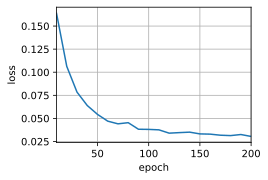

In [14]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_hiddens, num_heads = 64, 4

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), num_hiddens, ffn_num_hiddens, num_heads, num_layers,
    dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads, num_layers,
    dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

Após o treinamento,
nós usamos o modelo do transformador
para traduzir algumas frases em inglês para o francês e calcular suas pontuações BLEU.


In [15]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000


i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est calme !,  bleu 0.783


i'm home . => je suis chez moi suis bien <unk> .,  bleu 0.640


Vamos visualizar os pesos de atenção do transformador ao traduzir a última frase em inglês para o francês.
A forma dos pesos de autoatenção do *encoder*
é (número de camadas do codificador, número de *heads* de atenção, `num_steps` ou número de consultas,` num_steps` ou número de pares de valores-chave).


In [16]:
enc_attention_weights = np.concatenate(net.encoder.attention_weights, 0).reshape((num_layers,
    num_heads, -1, num_steps))
enc_attention_weights.shape

(2, 4, 10, 10)

Na autoatenção do *encoder*, tanto as consultas quanto as chaves vêm da mesma sequência de entrada. Como os tokens de preenchimento não têm significado, com o comprimento válido especificado da sequência de entrada, nenhuma consulta atende às posições dos tokens de preenchimento. A seguir, duas camadas de pesos de atenção de várias cabeças são apresentadas linha por linha. Cada *head* participa independentemente com base em subespaços de representação separados de consultas, chaves e valores.


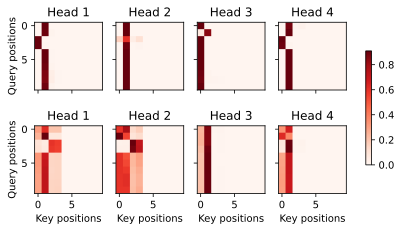

In [17]:
d2l.show_heatmaps(
    enc_attention_weights, xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

Para visualizar os pesos de autoatenção do *decoder* e os pesos de atenção do *encoder-decoder*, precisamos de mais manipulações de dados. Por exemplo, preenchemos os pesos de atenção mascarados com zero. Observe que os pesos de atenção do *decoder* e os pesos de atenção do *encoder-decoder* têm as mesmas consultas:
o token de início de sequência seguido pelos tokens de saída.


In [18]:
dec_attention_weights_2d = [np.array(head[0]).tolist()
                            for step in dec_attention_weight_seq
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = np.array(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.transpose(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

((2, 4, 9, 10), (2, 4, 9, 10))

Devido à propriedade auto-regressiva da autoatenção do *decoder*
nenhuma consulta atende aos pares de valores-chave após a posição da consulta.


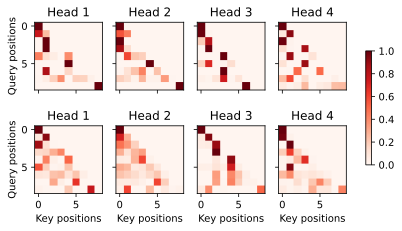

In [19]:
# Plus one to include the beginning-of-sequence token
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

Semelhante ao caso da autoatenção do *encoder*,
por meio do comprimento válido especificado da sequência de entrada,
nenhuma consulta da sequência de saída
atende a esses tokens de preenchimento da sequência de entrada.


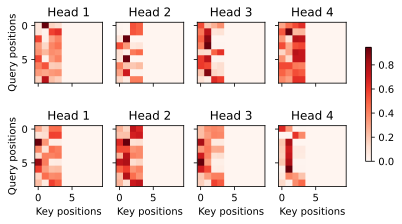

In [20]:
d2l.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

Embora a arquitetura do transformador tenha sido proposta originalmente para o aprendizado de sequência a sequência, como descobriremos mais tarde neste livro, ou o *encoder* do transformador ou o *decoder* do transformador
geralmente é usado individualmente para diferentes tarefas de *deep learning*.


## Resumo

* O transformador é uma instância da arquitetura do *encoder-decoder*, embora o *encoder* ou *decoder* possam ser usados individualmente na prática.
* No transformador, a autoatenção com várias *heads* é usada para representar a sequência de entrada e a sequência de saída, embora o *decoder* tenha que preservar a propriedade auto-regressiva por meio de uma versão mascarada.
* Ambas as conexões residuais e a normalização da camada no transformador são importantes para treinar um modelo muito profundo.
* A rede *feed-forward* posicional no modelo do transformador transforma a representação em todas as posições de sequência usando o mesmo MLP.


## Exercícios

1. Treine um transformador mais profundo nos experimentos. Como isso afeta a velocidade de treinamento e o desempenho da tradução?
1. É uma boa ideia substituir a atenção do produto escalonado com atenção aditiva no transformador? Por quê?
1. Para modelagem de linguagem, devemos usar o *encoder* do transformador, o *decoder* ou ambos? Como projetar este método?
1. Quais podem ser os desafios para os transformadores se as sequências de entrada forem muito longas? Por quê?
1. Como melhorar a eficiência computacional e de memória de transformadores? Dica: você pode consultar o artigo de pesquisa de Tay et al. :cite:`Tay.Dehghani.Bahri.ea.2020`.
1. Como podemos projetar modelos baseados em transformadores para tarefas de classificação de imagens sem usar CNNs? Dica: você pode consultar o transformador de visão :cite:`Dosovitskiy.Beyer.Kolesnikov.ea.2021`.


[Discussions](https://discuss.d2l.ai/t/348)


<!--stackedit_data:
eyJoaXN0b3J5IjpbLTQ4NTIzNTI2OSwtMTI0MzQzNzcwMywtMT
I2NDQ0ODE4MCwyMDAzNDczMjExLC00MjQ4NjgyNjEsLTIxNjE1
NTk2NywtNjUzMjg4NzgyLDcwOTc2MjUyMF19
-->
